In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023

In [2]:
# pv 24h + 28 weather features(5 temp, 3 precip, 5 prob_precip, 5 humid, 5 wind speed, 5 sky)

pv_features = pd.read_csv('./processed_data/pv_forecastweather_feature.csv')
pv_features = pv_features.rename(columns={'Unnamed: 0':'date'}).set_index('date', drop=True)
pv_features_length = len(pv_features)

pv_features.index = [str(idx) for idx in pv_features.index]

# X: 52 features, Y: 24 features
X = pv_features.iloc[0:pv_features_length-1].copy(deep=True)
Y = pv_features.iloc[1:pv_features_length][['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']].copy(deep=True)  # X and Y should be divided completely, so Y get deeply copied.

In [8]:
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)

In [9]:
dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()

In [10]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



# load forecast model에서 사용한 dataset 기간과 동일하게 설정
train_size = 186
mini_train_size = 148

train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 186개   210104 ~ 211015
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 47개    211018 ~ 211229
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 148개   210104 ~ 210819
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 38개    210820 ~ 211015

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

In [11]:
# same as model.ipynb
def train(model, trian_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(trian_dataloader.dataset)).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(52, 256)
        self.fc2 = nn.Linear(256, 1024)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(1024, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(1024)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output

In [13]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 40000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss()
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0


for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        # torch.save(model.state_dict(), './model.pt')
        # print('state_dict format of the model:\n{}'.format(model.state_dict()))
    if epoch % 1000 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}  |  Val Loss {:.6f}'.format(
            epoch, EPOCHS, mini_train_loss, val_loss))


print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/40000  |  Train Loss 2018.935425  |  Val Loss 33285.523438
Train Epoch: 1000/40000  |  Train Loss 27.579840  |  Val Loss 572.688416
Train Epoch: 2000/40000  |  Train Loss 3.418138  |  Val Loss 25.715757
Train Epoch: 3000/40000  |  Train Loss 0.805526  |  Val Loss 3.426016
Train Epoch: 4000/40000  |  Train Loss 0.146813  |  Val Loss 0.925586
Train Epoch: 5000/40000  |  Train Loss 0.037441  |  Val Loss 0.975163
Train Epoch: 6000/40000  |  Train Loss 0.024276  |  Val Loss 0.479052
Train Epoch: 7000/40000  |  Train Loss 0.002710  |  Val Loss 0.095638
Train Epoch: 8000/40000  |  Train Loss 0.122538  |  Val Loss 1.302303
Train Epoch: 9000/40000  |  Train Loss 0.000254  |  Val Loss 0.002409
Train Epoch: 10000/40000  |  Train Loss 0.505070  |  Val Loss 7.454228
Train Epoch: 11000/40000  |  Train Loss 0.001965  |  Val Loss 0.039384
Train Epoch: 12000/40000  |  Train Loss 0.030609  |  Val Loss 0.446432
Train Epoch: 13000/40000  |  Train Loss 0.000566  |  Val Loss 0.007240
Train

In [1]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 1000', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[1000:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[1000:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[2000:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[2000:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

NameError: name 'plt' is not defined

In [16]:
torch.save(model.state_dict(), './model_pt/pv_frcst_wthr_model_1024_40000.pt')

In [17]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()


for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 1000 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}'.format(
            epoch, best_val_epoch, train_loss))

Train Epoch:    0/24830  |  Train Loss 0.136656
Train Epoch: 1000/24830  |  Train Loss 0.056981
Train Epoch: 2000/24830  |  Train Loss 0.249325
Train Epoch: 3000/24830  |  Train Loss 0.016782
Train Epoch: 4000/24830  |  Train Loss 0.011350
Train Epoch: 5000/24830  |  Train Loss 0.013791
Train Epoch: 6000/24830  |  Train Loss 0.000062
Train Epoch: 7000/24830  |  Train Loss 0.083872
Train Epoch: 8000/24830  |  Train Loss 0.001859
Train Epoch: 9000/24830  |  Train Loss 0.013180
Train Epoch: 10000/24830  |  Train Loss 0.003867
Train Epoch: 11000/24830  |  Train Loss 0.000234
Train Epoch: 12000/24830  |  Train Loss 0.110833
Train Epoch: 13000/24830  |  Train Loss 0.004907
Train Epoch: 14000/24830  |  Train Loss 0.018460
Train Epoch: 15000/24830  |  Train Loss 0.045510
Train Epoch: 16000/24830  |  Train Loss 0.047893
Train Epoch: 17000/24830  |  Train Loss 0.000114
Train Epoch: 18000/24830  |  Train Loss 0.018425
Train Epoch: 19000/24830  |  Train Loss 0.078971
Train Epoch: 20000/24830  |  T

In [18]:
torch.save(model.state_dict(), './model_pt/pv_frcst_wthr_model_1024_40000_train.pt')

In [19]:
test_output, test_y = evaluate(model, test_dataloader)

# 6~20시에만 PV 발전량 존재. PV 발전량 음수는 안 나온다.
test_output = torch.where(test_output > 0, test_output, 0)  # 새롭게 추가된 코드!
test_output[:,0:6] = 0
test_output[:, 21:] = 0


test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
# test_mape = mape(test_output, test_y)


# TODO: MAPE 나타내보기.. 일부 값들만 선택해서!
print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
# print('MAPE(%): {:.6f}'.format(test_mape*100))  # 실제 정답값에 0이 포함되기 때문에 계산 불가능

Test Loss
MSE: 13777.208984
MAE: 56.598301


In [20]:
def plot(i, length, output, Y):
    fig = plt.figure(figsize=(20, 5))
    ax = plt.axes()
    plt.title('Actual and forecast PV generation for 20 days', fontsize = 18)
    plt.xlabel('Time (h)', fontsize = 15)
    plt.ylabel('Net-load', fontsize = 15)
    x_ticks = range(0,length*24, 24)
    x_labels = range(0, length)
    ax.set_xticks(x_ticks, x_labels)
    plt.plot(Y.detach().numpy()[i:i+(length*24),:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+(length*24),:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)


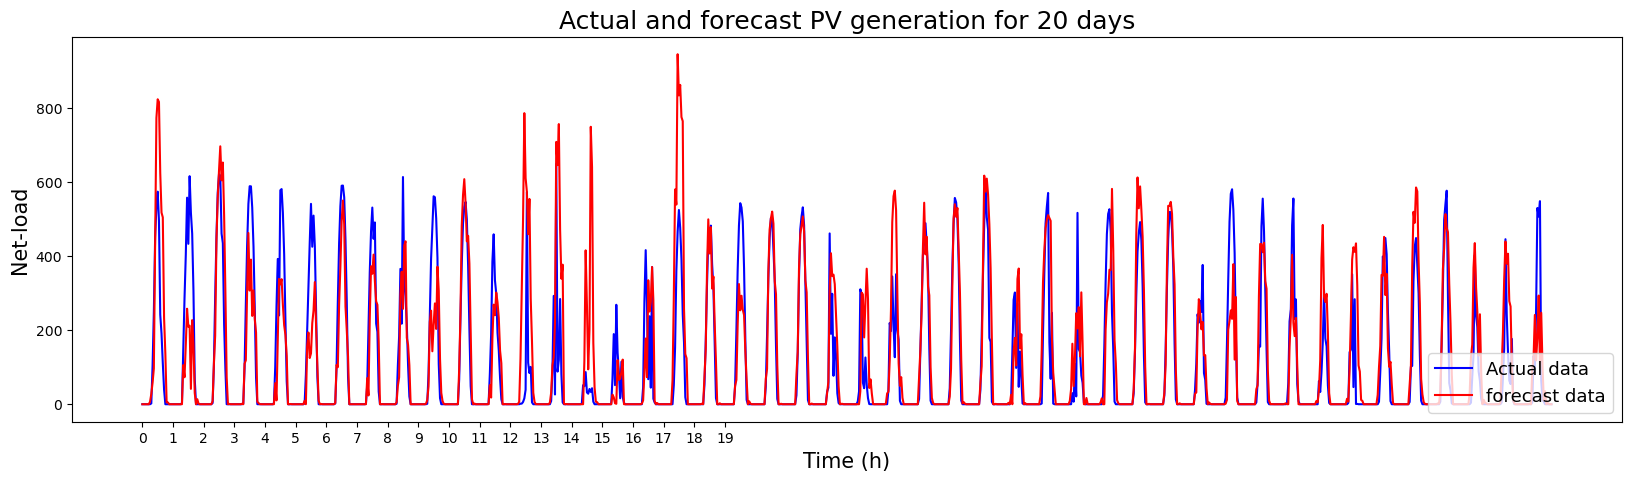

In [21]:
# 211020 ~ 211117
plot(1, 20, test_output, test_y)